# Map of all-season assessment data locations

**Summary**: In this notebook, we provide a single map showing the locations of the BGEP, IceBird and MOSAiC data overlaid on the summer IS-2 thickness data.  

**Author**: Alek Petty

**Version history**: Version 1 (09/25/2025)

In [1]:
# Regular Python library imports 
import xarray as xr 
import numpy as np
import pandas as pd
import pyproj
import scipy.interpolate
import matplotlib.pyplot as plt
import glob
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# Helper functions for reading the data from the bucket and plotting
from utils.read_data_utils import read_IS2SITMOGR4, read_book_data
from utils.plotting_utils import static_winter_comparison_lineplot, staticArcticMaps, interactiveArcticMaps, compute_gridcell_winter_means, interactive_winter_comparison_lineplot # Plotting utils 
from utils.extra_funcs import read_IS2SITMOGR4S, regrid_ubris_to_is2, get_cs2is2_snow, apply_interpolation_time
# Plotting dependencies
#%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

# Get the current working directory
current_directory = os.getcwd()

In [2]:
# Set some plotting parameters
mpl.rcParams.update({
    "text.usetex": False,  # Use LaTeX for rendering
    "font.family": "sans-serif",
    "lines.linewidth": 0.8,
    "font.size": 9,
    #"lines.alpha": 0.8,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 7
})
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['figure.dpi'] = 300 

In [3]:
# add '_int' if we want to mask using the interpolated/smoothed data. 
int_str='_int'

# Decide on which reanalysis SM-LG dataset to use
reanalysis = 'm2'



In [4]:
# Load the already wrangled data (see the relevant data wrangling notebook for more background on that)
IS2_CS2_allseason = xr.open_dataset('./data/book_data_allseason_v2.nc')
print("Successfully loaded all-season v1 wrangled dataset")

Successfully loaded all-season v1 wrangled dataset


In [5]:
# Get some map proj info needed for later functions
out_proj = 'EPSG:3411'
mapProj = pyproj.Proj("+init=" + out_proj)

xIS2 = IS2_CS2_allseason.x.values
yIS2 = IS2_CS2_allseason.y.values
xptsIS2, yptsIS2 = np.meshgrid(xIS2, yIS2)

out_lons = IS2_CS2_allseason.longitude.values
out_lats = IS2_CS2_allseason.latitude.values


In [6]:
IS2_CS2_allseason

<xarray.Dataset> Size: 990MB
Dimensions:                         (time: 33, y: 448, x: 304)
Coordinates:
  * time                            (time) datetime64[ns] 264B 2018-11-15 ......
  * x                               (x) float32 1kB -3.838e+06 ... 3.738e+06
  * y                               (y) float32 2kB 5.838e+06 ... -5.338e+06
    longitude                       (y, x) float32 545kB 168.3 168.1 ... -9.999
    latitude                        (y, x) float32 545kB 31.1 31.2 ... 34.47
Data variables: (12/53)
    crs                             (time) float64 264B ...
    ice_thickness_sm_e5             (time, y, x) float32 18MB ...
    ice_thickness_sm_m2             (time, y, x) float32 18MB ...
    ice_thickness_unc               (time, y, x) float32 18MB ...
    num_segments                    (time, y, x) float32 18MB ...
    mean_day_of_month               (time, y, x) float32 18MB ...
    ...                              ...
    snow_density_w99r_int           (time, y, x) float32 18MB ...
    ice_density_j22_int             (time, y, x) float32 18MB ...
    ice_thickness_cs2_ubris         (time, y, x) float64 36MB ...
    cs2_sea_ice_type_UBRIS          (time, y, x) float64 36MB ...
    cs2_sea_ice_density_UBRIS       (time, y, x) float64 36MB ...
    cs2is2_snow_depth               (time, y, x) float64 36MB ...
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  Aggregated IS2SITMOGR4 summer V1 dataset.
    history:      Created 23/07/25

In [7]:
# Inner Arctic domain (Central_Arctic Beaufort_Sea Chukchi_Sea East_Siberian_Sea Laptev_Sea Kara_Sea)
innerArctic = [1,2,3,4,5,6]
# Inner Arcic plus Barents and Greenland
#innerArctic = [1,2,3,4,5,6,7,8]

In [8]:
# Open the IB NetCDF file
grid_size=25
file_path = '/Users/akpetty/Data/IS2-obs-comparison-data/icebird_on_is2_grid_'+str(grid_size)+'km_test1.nc'
ib_dataset = xr.open_dataset(file_path)
ib_dataset = ib_dataset.rename({'date': 'time'})
ib_dataset = ib_dataset.transpose('y', 'x', 'time')
print(ib_dataset)

<xarray.Dataset> Size: 46MB
Dimensions:                   (x: 304, y: 448, time: 5)
Coordinates:
    lon                       (y, x) float64 1MB ...
    lat                       (y, x) float64 1MB ...
  * x                         (x) float64 2kB -3.838e+06 ... 3.738e+06
  * y                         (y) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time                      (time) datetime64[ns] 40B 2019-04-02 ... 2019-0...
    crs                       int32 4B ...
Data variables:
    sea_ice_thickness_mean    (y, x, time) float64 5MB ...
    sea_ice_thickness_median  (y, x, time) float64 5MB ...
    sea_ice_thickness_mode    (y, x, time) float64 5MB ...
    sea_ice_thickness_count   (y, x, time) float64 5MB ...
    snow_thickness_mean       (y, x, time) float64 5MB ...
    snow_thickness_median     (y, x, time) float64 5MB ...
    snow_thickness_mode       (y, x, time) float64 5MB ...
    snow_thickness_count      (y, x, time) float64 5MB ...


In [9]:
# Open SIMBA NetCDF file
grid_size=25
file_path = '/Users/akpetty/Data/IS2-obs-comparison-data/simba_snow_ice_mosaic_on_is2_grid_'+str(grid_size)+'km.nc'
simba_data = xr.open_dataset(file_path)
simba_data = simba_data.rename({'date': 'time'})
simba_data = simba_data.transpose('y', 'x', 'time')

print(simba_data)

<xarray.Dataset> Size: 587MB
Dimensions:                   (x: 304, y: 448, time: 269)
Coordinates:
    lon                       (y, x) float32 545kB ...
    lat                       (y, x) float32 545kB ...
  * x                         (x) float32 1kB -3.838e+06 ... 3.738e+06
  * y                         (y) float32 2kB 5.838e+06 5.812e+06 ... -5.338e+06
  * time                      (time) datetime64[ns] 2kB 2019-10-05 ... 2020-0...
    crs                       int32 4B ...
Data variables:
    sea_ice_thickness_mean    (y, x, time) float32 147MB ...
    sea_ice_thickness_median  (y, x, time) float32 147MB ...
    snow_thickness_mean       (y, x, time) float32 147MB ...
    snow_thickness_median     (y, x, time) float32 147MB ...


In [10]:
ib_dataset.sea_ice_thickness_mean.mean(dim='time')*0.

<xarray.DataArray 'sea_ice_thickness_mean' (y: 448, x: 304)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon      (y, x) float64 1MB ...
    lat      (y, x) float64 1MB ...
  * x        (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y        (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
    crs      int32 4B ...

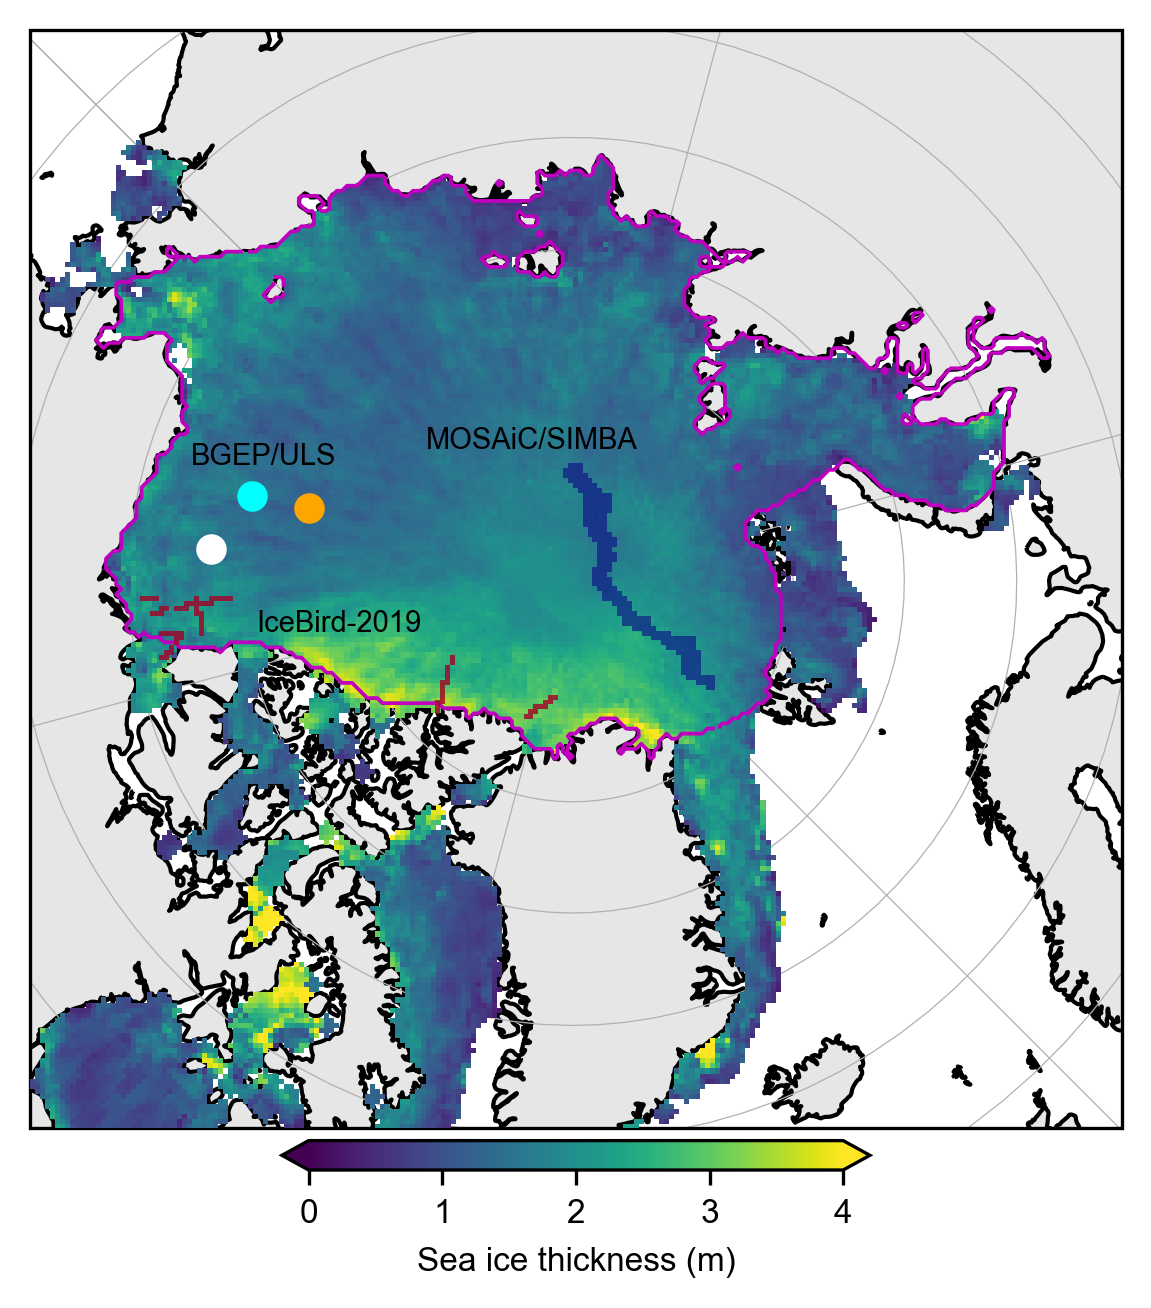

In [11]:
# Plot the mean summer thickness data just for broad context/check all is good. 

# Select only the summer months
summer_months = [5, 6, 7, 8]  # May=5, June=6, July=7, August=8
IS2_CS2_summer = IS2_CS2_allseason.sel(time=IS2_CS2_allseason.time.dt.month.isin(summer_months))

# Calculate the mean ice thickness over the summer months
mean_thickness = IS2_CS2_summer.ice_thickness_sm_m2_int.mean(dim='time')

plt.figure(figsize=(4, 4.4))
# Plot the region mask
im =mean_thickness.plot(x="longitude", y="latitude", transform=ccrs.PlateCarree(), cmap="viridis", zorder=3, 
            cbar_kwargs={'pad':0.01,'shrink': 0.5,'extend':'both', 'label':'Sea ice thickness (m)', 'location':'bottom'},
            vmin=0, vmax=4, 
            subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)})
ax = im.axes

ax.coastlines()
ax.add_feature(cfeature.LAND, color='0.9', zorder=1)

ax.set_extent([-179, 179, 65, 90], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=False, linewidth=0.3, zorder=5)

# Coordinates for BGEP/ULS in the Beaufort Sea
beaufort_sea_lona = -150 
beaufort_sea_lata = 75  

beaufort_sea_lonb = -150.5 
beaufort_sea_latb = 77.6 

beaufort_sea_lond = -140.2
beaufort_sea_latd = 73.6  

# Add markers for BGEP/ULS
ax.scatter(beaufort_sea_lona, beaufort_sea_lata, color='cyan', s=40, transform=ccrs.PlateCarree(), zorder=5)
ax.scatter(beaufort_sea_lonb, beaufort_sea_latb, color='orange', s=40, transform=ccrs.PlateCarree(), zorder=5)
ax.scatter(beaufort_sea_lond, beaufort_sea_latd, color='white', s=40, transform=ccrs.PlateCarree(), zorder=5)

# Create a binary region mask
region_mask = IS2_CS2_allseason.region_mask.isin(innerArctic).astype(int)

# Cartopy contour issue with NPS plots so split the data across the meridian
lon = mean_thickness.longitude
lat = mean_thickness.latitude

mask_west = lon < 0
mask_east = lon >= 0

ax.contour(lon.where(mask_west), lat, region_mask.where(mask_west), levels=[0.5], colors='m', linewidths=0.9, transform=ccrs.PlateCarree(), zorder=5)
ax.contour(lon.where(mask_east), lat, region_mask.where(mask_east), levels=[0.5], colors='m', linewidths=0.9, transform=ccrs.PlateCarree(), zorder=5)

im = ax.pcolormesh(
    ib_dataset.x, 
    ib_dataset.y, 
    ib_dataset.sea_ice_thickness_mean.mean(dim='time')*0., 
    transform=ccrs.NorthPolarStereo(central_longitude=-45),
    cmap='RdYlBu',
    zorder=5,
    alpha=0.8,
    vmin=0, 
    vmax=1000  # Adjust the range as needed
)

im = ax.pcolormesh(
    simba_data.x, 
    simba_data.y, 
    simba_data.sea_ice_thickness_mean.mean(dim='time')*0, 
    transform=ccrs.NorthPolarStereo(central_longitude=-45),
    cmap='plasma',
    zorder=5,
    alpha=0.6,
    vmin=0, 
    vmax=50  # Adjust the range as needed
)

ax.text(beaufort_sea_lona - 2, beaufort_sea_lata-3, 'BGEP/ULS', transform=ccrs.PlateCarree(), fontsize=7, color='black')
ax.text(-126,75.5, 'IceBird-2019', transform=ccrs.PlateCarree(), fontsize=7, color='black')
ax.text(183,81, 'MOSAiC/SIMBA', transform=ccrs.PlateCarree(), fontsize=7, color='black')


plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.0)
#plt.tight_layout()
plt.savefig('./figs/summer_mean_is2_map_tracks.png', dpi=300)
plt.show()